In [2]:
import json
import random
dataset = []
text_list = []
lines = []
count = 0
# Read file
with open("./RC_2015-01") as f:
    for line in f:
        lines.append(line)
        count += 1
        if count == 10000000:
            break
f.close()

# Shuffle array and store contents into a dictionary
random.Random(1).shuffle(lines)
for i in range(0, 100000):
    temp = json.loads(lines[i])
    if len(temp["body"]) < 512:
        temp_dict = {}
        if ("[deleted]" in temp["subreddit"]) or ("[deleted]" in temp["author"]) or ("[deleted]" in temp["body"]):
            continue
        temp_dict["downs"] = temp["downs"]
        temp_dict["ups"] = temp["ups"]
        temp_dict["subreddit"] = temp["subreddit"]
        temp_dict["author"] = temp["author"]
        temp_dict["body"] = temp["body"]
        text_list.append(temp["body"])
        dataset.append(temp_dict)
lines.clear()
print("Data processing complete.")


Data processing complete.


In [3]:
from transformers import pipeline
# Perform sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis")
tone = sentiment_pipeline(text_list)
sentiment_pipeline = pipeline("text-classification" , model='bhadresh-savani/distilbert-base-uncased-emotion')
emotion = sentiment_pipeline(text_list)

for i in range(0, len(dataset)):
    dataset[i]["tone"] = tone[i]["label"]
    dataset[i]["emotion"] = emotion[i]["label"]
text_list.clear()



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [4]:
tone_dict = {}
# Retrieve the subreddits and their tones
for i in range(0, len(dataset)):
    if dataset[i]['subreddit'] in tone_dict.keys():
        if dataset[i]['tone'] in tone_dict[dataset[i]['subreddit']].keys():
            tone_dict[dataset[i]['subreddit']][dataset[i]['tone']] = tone_dict[dataset[i]['subreddit']].get(dataset[i]['tone']) + 1
            tone_dict[dataset[i]['subreddit']]['size'] = tone_dict[dataset[i]['subreddit']].get('size') + 1
        else:
            tone_dict[dataset[i]['subreddit']][dataset[i]['tone']] = 1
            tone_dict[dataset[i]['subreddit']]['size'] = tone_dict[dataset[i]['subreddit']].get('size') + 1
    else:
        tone_dict[dataset[i]['subreddit']] = {dataset[i]['tone'] : 1, 'size' : 1} 
print("Dictionary created")
print(dataset)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
node_dict = {}
# Determine if a subreddit is NEGATIVE, POSITIVE, or INCONCLUSIVE
for key in tone_dict:
    node_dict[key] = {'size' : tone_dict[key]['size'], 'class' : 0}
    if 'NEGATIVE' not in tone_dict[key].keys():
        node_dict[key]['class'] = 1
        continue
    elif 'POSITIVE' not in tone_dict[key].keys():
        node_dict[key]['class'] = 0
        continue
    if tone_dict[key]['NEGATIVE'] > tone_dict[key]['POSITIVE']:
        node_dict[key]['class'] = 0
    elif tone_dict[key]['NEGATIVE'] < tone_dict[key]['POSITIVE']:
        node_dict[key]['class'] = 1
    else:
        node_dict[key]['class'] = 2
print("Dictionary created")

Dictionary created


In [6]:
mental_health_subreddits = [
        "mentalhealth",
        "depression",
        "anxiety",
        "ptsd",
        "bipolar",
        "schizophrenia",
        "ADHD",
        "OCD",
        "lonely",
        "stopselfharm",
        "suicidewatch",
        "BodyAcceptance",
        "traumatoolbox",
        "EatingDisorders",
        "anger",
        "selfhelp",
        "AskPsychology",
        "psychology",
        "therapy",
        "psychiatry",
        "mentalillness",
        "relationship_advice",
        "recovery",
        "mentalhealthsupport",
        "Anxietyhelp",
        "depression_help",
        "psychoticreddit",
        "ADHDwomen",
        "autism",
        "BPD",
        "ComplexPTSD",
        "CPTSD",
        "socialanxiety",
        "HealthAnxiety",
        "OCDmemes",
        "anxietymemes",
        "panicdisorder",
        "ADHD_Programmers",
        "ADHD_partners",
        "ADHD_Coaching",
        "ADHD_art",
        "ADHDwomen",
        "ADHD_success",
        "ADHDers",
        "ADHDmemes",
        "AdultADHD",
        "ADHD_support",
        "ADHDmood"
    ]

In [7]:
### Similar tones

In [8]:
import matplotlib.pyplot as plt
import numpy as np
# Print the user's general tone
user_dict = {}
for i in range(0, len(dataset)):
    if dataset[i]['author'] not in user_dict.keys():
        if dataset[i]['tone'] == 'POSITIVE':
            user_dict[dataset[i]['author']] = {'POSITIVE' : 1, 'NEGATIVE' : 0, 'subreddits' : []}
            user_dict[dataset[i]['author']]['subreddits'].append(dataset[i]['subreddit'])
        elif dataset[i]['tone'] == 'NEGATIVE':
            user_dict[dataset[i]['author']] = {'POSITIVE' : 0, 'NEGATIVE' : 1, 'subreddits' : []}
            user_dict[dataset[i]['author']]['subreddits'].append(dataset[i]['subreddit'])
    else:
        if dataset[i]['tone'] == 'POSITIVE':
            user_dict[dataset[i]['author']]['POSITIVE'] = user_dict[dataset[i]['author']].get('POSITIVE') + 1
            user_dict[dataset[i]['author']]['subreddits'].extend([dataset[i]['subreddit']])
        elif dataset[i]['tone'] == 'NEGATIVE':
            user_dict[dataset[i]['author']]['NEGATIVE'] = user_dict[dataset[i]['author']].get('NEGATIVE') + 1
            user_dict[dataset[i]['author']]['subreddits'].extend([dataset[i]['subreddit']])

user_tone = {}
for key in user_dict:
    if user_dict[key]['POSITIVE'] > user_dict[key]['NEGATIVE']:
        user_tone[key] = {'tone' : 'POSITIVE'}
        user_tone[key]['subreddits'] = list(set(user_dict[key]['subreddits']))
    else:
        user_tone[key] = {'tone' : 'NEGATIVE'}
        user_tone[key]['subreddits'] = list(set(user_dict[key]['subreddits']))

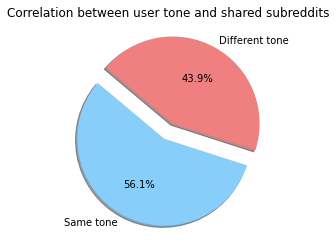

In [9]:
in_common = 0
not_common = 0
# Extract unique subreddits
all_subreddits = set()
for user, data in user_tone.items():
    all_subreddits.update(data['subreddits'])
sub_count = {}
for user1_index, (user1, data1) in enumerate(user_tone.items()):
    for user2_index, (user2, data2) in enumerate(user_tone.items()):
        if user1_index != user2_index:  # Avoid connecting a user with themselves
            common_subreddits = set(data1['subreddits']).intersection(data2['subreddits'])
            if common_subreddits:
                if data1['tone'] == data2 ['tone']:
                    in_common += 1
                else:
                    not_common += 1
mylabels = ["Same tone", "Different tone"]
y = np.array([in_common, not_common])
explode = (0.1,) * len(mylabels)
colors = ['lightskyblue', 'lightcoral']
plt.pie(y, explode=explode, labels=mylabels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Correlation between user tone and shared subreddits')
plt.savefig('graph3.png')
plt.show() 

In [10]:
### Tones in Subreddit

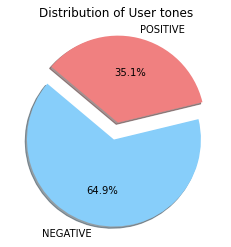

In [11]:
neg_count = 0
pos_count = 0
for key, value in user_tone.items():
    if value['tone'] == 'NEGATIVE':
        neg_count += 1
    else:
        pos_count += 1

mylabels = ["NEGATIVE", "POSITIVE"]
y = np.array([neg_count, pos_count])
explode = (0.1,) * len(mylabels)
colors = ['lightskyblue', 'lightcoral']
plt.pie(y, explode=explode, labels=mylabels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of User tones')
plt.savefig('tone_graph.png')
plt.show() 

In [12]:
### Averaging Emotions

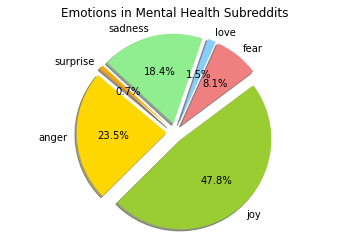

In [13]:
from collections import defaultdict
import matplotlib.pyplot as plt

def tally_emotions(data):
    mental_health_subreddits = [
        "mentalhealth",
        "depression",
        "anxiety",
        "ptsd",
        "bipolar",
        "schizophrenia",
        "ADHD",
        "OCD",
        "lonely",
        "stopselfharm",
        "suicidewatch",
        "BodyAcceptance",
        "traumatoolbox",
        "EatingDisorders",
        "anger",
        "selfhelp",
        "AskPsychology",
        "psychology",
        "therapy",
        "psychiatry",
        "mentalillness",
        "relationship_advice",
        "recovery",
        "mentalhealthsupport",
        "Anxietyhelp",
        "depression_help",
        "psychoticreddit",
        "ADHDwomen",
        "autism",
        "BPD",
        "ComplexPTSD",
        "CPTSD",
        "socialanxiety",
        "HealthAnxiety",
        "OCDmemes",
        "anxietymemes",
        "panicdisorder",
        "ADHD_Programmers",
        "ADHD_partners",
        "ADHD_Coaching",
        "ADHD_art",
        "ADHDwomen",
        "ADHD_success",
        "ADHDers",
        "ADHDmemes",
        "AdultADHD",
        "ADHD_support",
        "ADHDmood"
    ]

    emotion_tally = defaultdict(int)

    for entry in data:
        subreddit = entry.get("subreddit", "").lower().replace("r/", "")
        if subreddit in mental_health_subreddits:
            emotion = entry.get("emotion", "")
            emotion_tally[emotion] += 1
    return emotion_tally


emotion_counts = tally_emotions(dataset)

# Create a pie chart
labels = emotion_counts.keys()
sizes = emotion_counts.values()
colors = ['gold', 'yellowgreen', 'lightskyblue', 'lightcoral', 'lightgreen', 'orange']
explode = (0.1,) * len(labels)  # explode all slices

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('All emotions in Mental Health Subreddits')
plt.show()


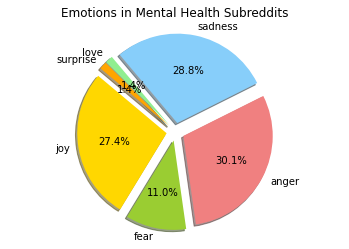

In [14]:
from collections import defaultdict
import matplotlib.pyplot as plt

def tally_emotions(data):
    mental_health_subreddits = [
        "mentalhealth",
        "depression",
        "anxiety",
        "ptsd",
        "bipolar",
        "schizophrenia",
        "ADHD",
        "OCD",
        "lonely",
        "stopselfharm",
        "suicidewatch",
        "BodyAcceptance",
        "traumatoolbox",
        "EatingDisorders",
        "anger",
        "selfhelp",
        "AskPsychology",
        "psychology",
        "therapy",
        "psychiatry",
        "mentalillness",
        "relationship_advice",
        "recovery",
        "mentalhealthsupport",
        "Anxietyhelp",
        "depression_help",
        "psychoticreddit",
        "ADHDwomen",
        "autism",
        "BPD",
        "ComplexPTSD",
        "CPTSD",
        "socialanxiety",
        "HealthAnxiety",
        "OCDmemes",
        "anxietymemes",
        "panicdisorder",
        "ADHD_Programmers",
        "ADHD_partners",
        "ADHD_Coaching",
        "ADHD_art",
        "ADHDwomen",
        "ADHD_success",
        "ADHDers",
        "ADHDmemes",
        "AdultADHD",
        "ADHD_support",
        "ADHDmood"
    ]

    emotion_tally = defaultdict(int)

    for entry in data:
        subreddit = entry.get("subreddit", "").lower().replace("r/", "")
        if subreddit in mental_health_subreddits:
            if entry['tone'] == 'NEGATIVE':
                emotion = entry.get("emotion", "")
                emotion_tally[emotion] += 1
    return emotion_tally


emotion_counts = tally_emotions(dataset)

# Create a pie chart
labels = emotion_counts.keys()
sizes = emotion_counts.values()
colors = ['yellowgreen', 'lightskyblue', 'gold', 'lightgreen', 'lightcoral', 'orange']
explode = (0.1,) * len(labels)  # explode all slices

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Emotions with a negative tone in Mental Health Subreddits')
plt.show()


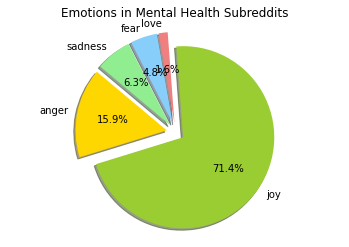

In [15]:
from collections import defaultdict
import matplotlib.pyplot as plt

def tally_emotions(data):
    mental_health_subreddits = [
        "mentalhealth",
        "depression",
        "anxiety",
        "ptsd",
        "bipolar",
        "schizophrenia",
        "ADHD",
        "OCD",
        "lonely",
        "stopselfharm",
        "suicidewatch",
        "BodyAcceptance",
        "traumatoolbox",
        "EatingDisorders",
        "anger",
        "selfhelp",
        "AskPsychology",
        "psychology",
        "therapy",
        "psychiatry",
        "mentalillness",
        "relationship_advice",
        "recovery",
        "mentalhealthsupport",
        "Anxietyhelp",
        "depression_help",
        "psychoticreddit",
        "ADHDwomen",
        "autism",
        "BPD",
        "ComplexPTSD",
        "CPTSD",
        "socialanxiety",
        "HealthAnxiety",
        "OCDmemes",
        "anxietymemes",
        "panicdisorder",
        "ADHD_Programmers",
        "ADHD_partners",
        "ADHD_Coaching",
        "ADHD_art",
        "ADHDwomen",
        "ADHD_success",
        "ADHDers",
        "ADHDmemes",
        "AdultADHD",
        "ADHD_support",
        "ADHDmood"
    ]

    emotion_tally = defaultdict(int)

    for entry in data:
        subreddit = entry.get("subreddit", "").lower().replace("r/", "")
        if subreddit in mental_health_subreddits:
            if entry['tone'] == 'POSITIVE':
                emotion = entry.get("emotion", "")
                emotion_tally[emotion] += 1
    return emotion_tally


emotion_counts = tally_emotions(dataset)

# Create a pie chart
labels = emotion_counts.keys()
sizes = emotion_counts.values()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'orange']
explode = (0.1,) * len(labels)  # explode all slices

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Emotions with a positive tone in Mental Health Subreddits')
plt.show()


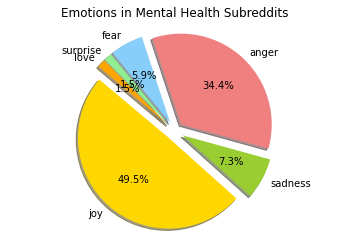

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt

def tally_emotions(data):
    mental_health_subreddits = [
        "mentalhealth",
        "depression",
        "anxiety",
        "ptsd",
        "bipolar",
        "schizophrenia",
        "ADHD",
        "OCD",
        "lonely",
        "stopselfharm",
        "suicidewatch",
        "BodyAcceptance",
        "traumatoolbox",
        "EatingDisorders",
        "anger",
        "selfhelp",
        "AskPsychology",
        "psychology",
        "therapy",
        "psychiatry",
        "mentalillness",
        "relationship_advice",
        "recovery",
        "mentalhealthsupport",
        "Anxietyhelp",
        "depression_help",
        "psychoticreddit",
        "ADHDwomen",
        "autism",
        "BPD",
        "ComplexPTSD",
        "CPTSD",
        "socialanxiety",
        "HealthAnxiety",
        "OCDmemes",
        "anxietymemes",
        "panicdisorder",
        "ADHD_Programmers",
        "ADHD_partners",
        "ADHD_Coaching",
        "ADHD_art",
        "ADHDwomen",
        "ADHD_success",
        "ADHDers",
        "ADHDmemes",
        "AdultADHD",
        "ADHD_support",
        "ADHDmood"
    ]

    emotion_tally = defaultdict(int)

    for entry in data:
        subreddit = entry.get("subreddit", "").lower().replace("r/", "")
        if not subreddit in mental_health_subreddits:
            emotion = entry.get("emotion", "")
            emotion_tally[emotion] += 1
    return emotion_tally

emotion_counts = tally_emotions(dataset)

# Create a pie chart
labels = emotion_counts.keys()
sizes = emotion_counts.values()
colors = ['yellowgreen', 'lightgreen', 'gold', 'lightskyblue', 'orange', 'lightcoral']
explode = (0.1,) * len(labels)  # explode all slices

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('All Emotions in Non-mental Health Subreddits')
plt.show()


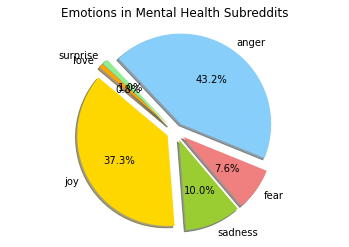

In [17]:
from collections import defaultdict
import matplotlib.pyplot as plt

def tally_emotions(data):
    mental_health_subreddits = [
        "mentalhealth",
        "depression",
        "anxiety",
        "ptsd",
        "bipolar",
        "schizophrenia",
        "ADHD",
        "OCD",
        "lonely",
        "stopselfharm",
        "suicidewatch",
        "BodyAcceptance",
        "traumatoolbox",
        "EatingDisorders",
        "anger",
        "selfhelp",
        "AskPsychology",
        "psychology",
        "therapy",
        "psychiatry",
        "mentalillness",
        "relationship_advice",
        "recovery",
        "mentalhealthsupport",
        "Anxietyhelp",
        "depression_help",
        "psychoticreddit",
        "ADHDwomen",
        "autism",
        "BPD",
        "ComplexPTSD",
        "CPTSD",
        "socialanxiety",
        "HealthAnxiety",
        "OCDmemes",
        "anxietymemes",
        "panicdisorder",
        "ADHD_Programmers",
        "ADHD_partners",
        "ADHD_Coaching",
        "ADHD_art",
        "ADHDwomen",
        "ADHD_success",
        "ADHDers",
        "ADHDmemes",
        "AdultADHD",
        "ADHD_support",
        "ADHDmood"
    ]

    emotion_tally = defaultdict(int)

    for entry in data:
        subreddit = entry.get("subreddit", "").lower().replace("r/", "")
        if not subreddit in mental_health_subreddits:
            if entry['tone'] == 'NEGATIVE':
                emotion = entry.get("emotion", "")
                emotion_tally[emotion] += 1
    return emotion_tally


emotion_counts = tally_emotions(dataset)

# Create a pie chart
labels = emotion_counts.keys()
sizes = emotion_counts.values()
colors = ['yellowgreen', 'lightgreen', 'lightskyblue', 'gold', 'orange', 'lightcoral']
explode = (0.1,) * len(labels)  # explode all slices

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Emotions with a negative tone in Non-mental Health Subreddits')
plt.show()


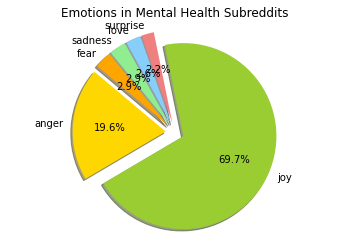

In [18]:
from collections import defaultdict
import matplotlib.pyplot as plt

def tally_emotions(data):
    mental_health_subreddits = [
        "mentalhealth",
        "depression",
        "anxiety",
        "ptsd",
        "bipolar",
        "schizophrenia",
        "ADHD",
        "OCD",
        "lonely",
        "stopselfharm",
        "suicidewatch",
        "BodyAcceptance",
        "traumatoolbox",
        "EatingDisorders",
        "anger",
        "selfhelp",
        "AskPsychology",
        "psychology",
        "therapy",
        "psychiatry",
        "mentalillness",
        "relationship_advice",
        "recovery",
        "mentalhealthsupport",
        "Anxietyhelp",
        "depression_help",
        "psychoticreddit",
        "ADHDwomen",
        "autism",
        "BPD",
        "ComplexPTSD",
        "CPTSD",
        "socialanxiety",
        "HealthAnxiety",
        "OCDmemes",
        "anxietymemes",
        "panicdisorder",
        "ADHD_Programmers",
        "ADHD_partners",
        "ADHD_Coaching",
        "ADHD_art",
        "ADHDwomen",
        "ADHD_success",
        "ADHDers",
        "ADHDmemes",
        "AdultADHD",
        "ADHD_support",
        "ADHDmood"
    ]

    emotion_tally = defaultdict(int)

    for entry in data:
        subreddit = entry.get("subreddit", "").lower().replace("r/", "")
        if not subreddit in mental_health_subreddits:
            if entry['tone'] == 'POSITIVE':
                emotion = entry.get("emotion", "")
                emotion_tally[emotion] += 1
    return emotion_tally

emotion_counts = tally_emotions(dataset)

# Create a pie chart
labels = emotion_counts.keys()
sizes = emotion_counts.values()
colors = ['gold', 'yellowgreen', 'orange', 'lightcoral', 'lightgreen', 'lightskyblue']
explode = (0.1,) * len(labels)  # explode all slices

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Emotions with a positive tone in Non-mental Health Subreddits')
plt.show()


In [19]:
### Topic Extraction

In [20]:
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Define stopwords and lemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Preprocess Text - Extract, clean, lemmatize
def preprocess_text(text):
    text = text.lower()  # Lowercase
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return tokens

# Prepare Corpus - Extract body text and preprocess
corpus_by_subreddit = {}
for post in dataset:
    if post['subreddit'] in mental_health_subreddits:
        subreddit = post["subreddit"]
        if subreddit not in corpus_by_subreddit:
            corpus_by_subreddit[subreddit] = []
        corpus_by_subreddit[subreddit].append(preprocess_text(post["body"]))

# Train LDA Model for each subreddit in the list with your dataset
num_topics = 2
lda_models_custom_data = {}
for subreddit, subreddit_corpus in corpus_by_subreddit.items():
        print(f"Subreddit: {subreddit}, Number of Preprocessed Comments: {len(subreddit_corpus)}")
        
        # Train LDA model for the subreddit
        dictionary = gensim.corpora.Dictionary(subreddit_corpus)
        bow_corpus = [dictionary.doc2bow(doc) for doc in subreddit_corpus]
        lda_model = gensim.models.LdaMulticore(bow_corpus, id2word=dictionary, num_topics=num_topics)
        lda_models_custom_data[subreddit] = lda_model
        
        # Print top words per topic
        print(f"\nTop Words per Topic for {subreddit}:")
        topics = lda_model.print_topics()
        for topic_id, topic in enumerate(topics):
            try:
                top_words = [word.split('*')[1].strip().replace('"', '') for word in topic[1].split('+')]
            except:
                continue
            print(f"Topic {topic_id+1}:", top_words)
        print()


Subreddit: relationship_advice, Number of Preprocessed Comments: 44

Top Words per Topic for relationship_advice:
Topic 1: ['like', 'going', 'want', 'need', 'think', 'dog', 'get', 'find', 'person', 'right']
Topic 2: ['know', 'get', 'going', 'like', 'way', 'would', 'really', 'think', 'want', "i'm"]

Subreddit: depression, Number of Preprocessed Comments: 30

Top Words per Topic for depression:
Topic 1: ["i'm", 'year', 'get', 'feel', 'going', 'one', 'know', 'hope', 'like', 'that.']
Topic 2: ["i'm", 'trying', 'get', 'hope', 'feeling', 'really', 'good', 'well', 'something', 'like']

Subreddit: ADHD, Number of Preprocessed Comments: 11

Top Words per Topic for ADHD:
Topic 1: ['medication', 'find', 'get', 'already', 'behavior.', 'drug', 'think', 'mind', 'function', 'use']
Topic 2: ['get', "i'd", 'like', 'me.', 'doctor', 'sound', 'find', 'parent.', 'unfortunately,', 'kid']

Subreddit: psychology, Number of Preprocessed Comments: 4

Top Words per Topic for psychology:
Topic 1: ["i'm", 'depends

In [21]:
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Define stopwords and lemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Preprocess Text - Extract, clean, lemmatize
def preprocess_text(text):
    text = text.lower()  # Lowercase
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return tokens

# Prepare Corpus - Extract body text and preprocess
corpus_by_subreddit = {}
for post in dataset:
    if not post['subreddit'] in mental_health_subreddits:
        subreddit = post["subreddit"]
        if subreddit not in corpus_by_subreddit:
            corpus_by_subreddit[subreddit] = []
        corpus_by_subreddit[subreddit].append(preprocess_text(post["body"]))

# Train LDA Model for each subreddit in the list with your dataset
num_topics = 2
lda_models_custom_data = {}
for subreddit, subreddit_corpus in corpus_by_subreddit.items():
    if len(subreddit_corpus) >= 50:
        print(f"Subreddit: {subreddit}, Number of Preprocessed Comments: {len(subreddit_corpus)}")
        
        # Train LDA model for the subreddit
        dictionary = gensim.corpora.Dictionary(subreddit_corpus)
        bow_corpus = [dictionary.doc2bow(doc) for doc in subreddit_corpus]
        lda_model = gensim.models.LdaMulticore(bow_corpus, id2word=dictionary, num_topics=num_topics)
        lda_models_custom_data[subreddit] = lda_model
        
        # Print top words per topic
        print(f"\nTop Words per Topic for {subreddit}:")
        topics = lda_model.print_topics()
        for topic_id, topic in enumerate(topics):
            try:
                top_words = [word.split('*')[1].strip().replace('"', '') for word in topic[1].split('+')]
            except:
                continue
            print(f"Topic {topic_id+1}:", top_words)
        print()


Subreddit: nfl, Number of Preprocessed Comments: 1904

Top Words per Topic for nfl:
Topic 1: ['game', 'like', 'would', 'team', 'one', 'think', 'call', "i'm", 'fan', 'get']
Topic 2: ['like', 'game', 'would', 'get', "he's", 'one', 'think', 'good', 'team', 'play']

Subreddit: Planetside, Number of Preprocessed Comments: 143

Top Words per Topic for Planetside:
Topic 1: ['like', 'think', 'game', 'people', 'really', 'want', 'good', "that's", 'get', 'player']
Topic 2: ['game', 'like', 'make', 'need', 'implant', 'get', 'new', 'think', 'thing', "i'm"]

Subreddit: AskReddit, Number of Preprocessed Comments: 7709

Top Words per Topic for AskReddit:
Topic 1: ['like', "i'm", 'people', 'would', 'really', 'time', 'get', 'one', 'make', 'thing']
Topic 2: ['like', 'get', 'would', 'one', 'think', 'people', "i'm", 'it.', 'even', 'know']

Subreddit: ffxiv, Number of Preprocessed Comments: 118

Top Words per Topic for ffxiv:
Topic 1: ['get', 'like', "i'm", 'level', 'want', 'way', 'take', 'weapon', 'job', '


Top Words per Topic for starcitizen:
Topic 1: ['game', 'get', 'think', 'like', 'people', 'work', 'would', 'one', 'see', 'want']
Topic 2: ['like', 'game', 'see', 'get', 'think', "i'm", 'would', 'pretty', 'one', 'need']

Subreddit: relationships, Number of Preprocessed Comments: 308

Top Words per Topic for relationships:
Topic 1: ['like', 'want', 'think', 'know', 'really', 'get', 'would', "i'm", 'good', 'need']
Topic 2: ['like', 'get', 'think', 'know', 'want', 'one', 'need', 'would', 'time', 'feel']

Subreddit: pokemontrades, Number of Preprocessed Comments: 384

Top Words per Topic for pokemontrades:
Topic 1: ["i'm", '', 'one', ':)', "i'll", 'interested', 'would', 'trade', 'need', 'get']
Topic 2: [':)', 'trade', "i'll", "i'm", 'got', 'thanks', 'one', 'get', 'know', 'ha']

Subreddit: movies, Number of Preprocessed Comments: 586

Top Words per Topic for movies:
Topic 1: ['movie', 'like', 'one', 'get', 'people', 'think', 'would', 'time', 'really', "i'm"]
Topic 2: ['movie', 'like', 'would


Top Words per Topic for starcraft:
Topic 1: ['really', 'get', 'still', "he's", 'people', 'would', 'much', 'sure', 'time', 'think']
Topic 2: ['game', 'really', 'one', 'people', 'think', 'like', 'starcraft', 'much', "i'm", 'make']

Subreddit: POLITIC, Number of Preprocessed Comments: 64

Top Words per Topic for POLITIC:
Topic 1: ['submission', '[original', '[removed', 'fucking', 'cost', '/r/news](http://reddit.com/r/news/comments/2rhwdj/samsung_announced_about_the_new_super_uhd_tvs_at/)', 'topic]', '[off', 'insurance', '/r/worldnews](/r/worldnews/comments/2rd8ud/is_ehsanullah_ehsan_taliban_spokesperson/)']
Topic 2: ['[removed', '[original', 'submission', 'fucking', 'cost', 'insurance', '/r/politics](http://reddit.com/r/politics/comments/2rgj24/black_panthers_in_dallas_are_responding_to_police/)', '[off-topic]', 'state', 'publish']

Subreddit: Android, Number of Preprocessed Comments: 170

Top Words per Topic for Android:
Topic 1: ['phone', 'android', 'app', 'really', "i'm", 'one', 'like


Top Words per Topic for india:
Topic 1: ['like', '&gt;', 'think', 'people', 'get', 'see', 'know', 'u', 'india', 'make']
Topic 2: ['get', 'u', 'people', 'india', 'know', 'see', '&gt;', 'guy', 'make', 'like']

Subreddit: Jokes, Number of Preprocessed Comments: 91

Top Words per Topic for Jokes:
Topic 1: ['joke', 'think', 'get', '2,', "i'm", 'bokeh', "that's", '-', 'thing', 'know']
Topic 2: ['like', '=', 'get', 'go', 'said', 'come', 'also', 'look', 'that.', 'would']

Subreddit: AskWomen, Number of Preprocessed Comments: 202

Top Words per Topic for AskWomen:
Topic 1: ["i'm", 'like', 'get', 'would', 'really', 'one', 'never', 'people', 'make', 'thing']
Topic 2: ['like', "i'm", 'make', 'really', "i've", 'one', 'think', 'much', "that's", 'never']

Subreddit: worldnews, Number of Preprocessed Comments: 815

Top Words per Topic for worldnews:
Topic 1: ['people', 'would', 'get', 'like', 'u', 'think', "that's", "i'm", 'know', 'want']
Topic 2: ['like', 'people', 'would', 'think', 'get', 'even', '


Top Words per Topic for TrollXChromosomes:
Topic 1: ["i'm", 'like', 'woman', 'people', 'think', 'get', 'one', "that's", 'look', 'back']
Topic 2: ["i'm", "i've", 'like', 'one', 'really', 'thing', 'make', 'love', 'it.', "that's"]

Subreddit: comicbooks, Number of Preprocessed Comments: 63

Top Words per Topic for comicbooks:
Topic 1: ['', 'one', 'would', 'get', 'like', 'back', 'never', 'try', 'run', 'issue']
Topic 2: ['', 'would', 'like', '(of', 'comic', 'people', 'new', 'get', 'issue', 'it.']

Subreddit: DarkSouls2, Number of Preprocessed Comments: 120

Top Words per Topic for DarkSouls2:
Topic 1: ['like', 'one', 'get', 'make', 'would', 'game', 'got', 'look', 'sign', 'way']
Topic 2: ["i'm", 'really', 'one', 'like', 'look', 'also', 'get', 'think', 'hit', 'see']

Subreddit: tifu, Number of Preprocessed Comments: 246

Top Words per Topic for tifu:
Topic 1: ['get', 'like', 'know', 'would', "i'm", 'friend', 'one', 'think', 'feel', 'really']
Topic 2: ["that's", 'get', 'like', 'one', 'would',


Top Words per Topic for canada:
Topic 1: ['like', 'make', 'ole', 'think', 'go', 'would', 'one', 'get', "i'm", 'want']
Topic 2: ['would', 'get', 'it.', 'also', 'one', "i'm", 'like', 'know', "i've", 'sure']

Subreddit: technology, Number of Preprocessed Comments: 285

Top Words per Topic for technology:
Topic 1: ['like', 'people', 'get', 'would', 'see', 'one', 'time', "can't", "that's", 'much']
Topic 2: ['like', 'one', 'people', 'would', 'get', 'make', 'need', 'thing', 'even', 'phone']

Subreddit: KerbalSpaceProgram, Number of Preprocessed Comments: 76

Top Words per Topic for KerbalSpaceProgram:
Topic 1: ["i'm", 'thing', 'like', 'it.', 'get', 'action', 'one', "i've", 'see', 'know']
Topic 2: ['work', "i've", 'kerbal', 'need', 'see', 'one', 'rocket', 'got', 'may', 'since']

Subreddit: wiiu, Number of Preprocessed Comments: 64

Top Words per Topic for wiiu:
Topic 1: ['wii', 'u', 'like', 'mario', 'great', 'one', 'nintendo', 'really', 'make', 'would']
Topic 2: ['game', 'wii', 'get', 'like',


Top Words per Topic for pathofexile:
Topic 1: ['like', 'would', 'make', 'get', 'it.', 'party', 'spell', 'think', 'using', 'use']
Topic 2: ['game', 'mana', 'like', 'get', 'would', 'work', 'map', 'make', 'much', '666,']

Subreddit: Patriots, Number of Preprocessed Comments: 61

Top Words per Topic for Patriots:
Topic 1: ['team', 'people', 'would', 'get', 'pat', 'like', 'well', 'bar', 'could', 'good']
Topic 2: ['yard', 'game', 'raven', 'going', 'like', 'get', "i'm", 'would', 'people', 'nice']

Subreddit: roosterteeth, Number of Preprocessed Comments: 56

Top Words per Topic for roosterteeth:
Topic 1: ['play', 'one', 'like', 'gavin', 'much', 'time.', 'game', 'different', 'think', 'made']
Topic 2: ['think', 'ray', 'might', 'post', 'like', "i'm", 'one', 'know', 'guy', 'two']

Subreddit: SVExchange, Number of Preprocessed Comments: 279

Top Words per Topic for SVExchange:
Topic 1: [':)', 'egg', 'hatch', '', "i'll", 'match', '-', "i'm", 'online', 'sorry']
Topic 2: [':)', 'egg', "i'm", '|', 't


Top Words per Topic for Guildwars2:
Topic 1: ['get', "i'm", 'like', 'need', 'new', 'think', 'go', 'people', 'thing', 'every']
Topic 2: ['get', 'like', 'going', 'say', "i'm", 'much', 'every', 'thing', 'lot', 'need']

Subreddit: BabyBumps, Number of Preprocessed Comments: 76

Top Words per Topic for BabyBumps:
Topic 1: ['know', 'one', "i'm", 'never', 'like', ':)', 'people', 'think', 'day', 'much']
Topic 2: ["i'm", 'get', ':)', 'like', 'one', 'much', 'thing', 'thanks', 'going', 'pretty']

Subreddit: Steam, Number of Preprocessed Comments: 106

Top Words per Topic for Steam:
Topic 1: ['steam', 'get', 'game', 'use', 'like', 'sale', 'play', 'time', 'could', '2']
Topic 2: ['game', 'steam', 'would', 'buy', 'people', 'get', 'could', 'still', 'sale', 'like']

Subreddit: personalfinance, Number of Preprocessed Comments: 160

Top Words per Topic for personalfinance:
Topic 1: ['like', 'would', "i'm", 'money', 'pay', 'want', 'go', 'know', 'year', "that's"]
Topic 2: ['would', 'get', 'good', 'make', 


Top Words per Topic for steelers:
Topic 1: ['back', 'game', 'got', 'know', 'fuck', 'good', 'one', 'him.', 'think', "i'm"]
Topic 2: ['fuck', 'raven', 'got', 'good', 'game', 'like', 'fan', 'go', 'harrison', "he's"]

Subreddit: photography, Number of Preprocessed Comments: 72

Top Words per Topic for photography:
Topic 1: ['like', 'get', 'need', "i'm", 'look', 'similar', 'photo', 'first', 'would', 'something']
Topic 2: ['get', "i'm", 'camera', 'like', 'first', 'good', 'give', 'look', 'pretty', 'one']

Subreddit: bindingofisaac, Number of Preprocessed Comments: 102

Top Words per Topic for bindingofisaac:
Topic 1: ['would', 'heart', 'like', 'get', 'tear', 'make', 'item', 'since', 'room', 'damage']
Topic 2: ['get', 'would', 'item', 'lost', 'first', 'like', 'even', 'make', 'one', "that's"]

Subreddit: programming, Number of Preprocessed Comments: 70

Top Words per Topic for programming:
Topic 1: ['people', 'use', 'like', "i've", 'language', 'point', 'noise', 'still', 'want', 'would']
Topic 